# Inpainting missing data

Missing data in an image can be an issue, especially when one wants to perform Fourier analysis.
This tutorial explains how to fill-up missing pixels with values which looks "realistic" and introduce as little perturbation as possible for subsequent analysis.
The user should keep the mask nearby and only consider the values of actual pixels and never the one inpainted.

This tutorial will use fully synthetic data to allow comparison between actual (syntetic) data with inpainted values.

The first part of the tutorial is about the generation of a challenging 2D diffraction image with realistic noise and to describe the metric used, then comes the actual tutorial on how to use the inpainting. Finally a benchmark is used based on the metric determined.

## Creation of the image

A realistic challenging image should contain:

* Bragg peak rings. We chose LaB6 as guinea-pig, with very sharp peaks, at the limit of the resolution of the detector
* Some amorphous content
* strong polarization effect
* Poissonian noise


One image will be generated but then multiple ones with different noise to discriminate the effect of the noise from other effects.

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyFAI
print("Using pyFAI version: ", pyFAI.version)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui import jupyter
import pyFAI.test.utilstest
from pyFAI.calibrant import get_calibrant
import time
start_time = time.time()

Using pyFAI version:  0.18.0-dev1


In [3]:
detector = pyFAI.detector_factory("Pilatus2MCdTe")
mask = detector.mask.copy()
nomask = numpy.zeros_like(mask)
detector.mask=nomask
ai = AzimuthalIntegrator(detector=detector)
ai.setFit2D(200, 200, 200)
ai.wavelength = 3e-11
print(ai)

Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 3.000000e-11m
SampleDetDist= 2.000000e-01m	PONI= 3.440000e-02, 3.440000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 200.000mm	Center: x=200.000, y=200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


LaB6 Calibrant with 640 reflections at wavelength 3e-11


<IPython.core.display.Javascript object>


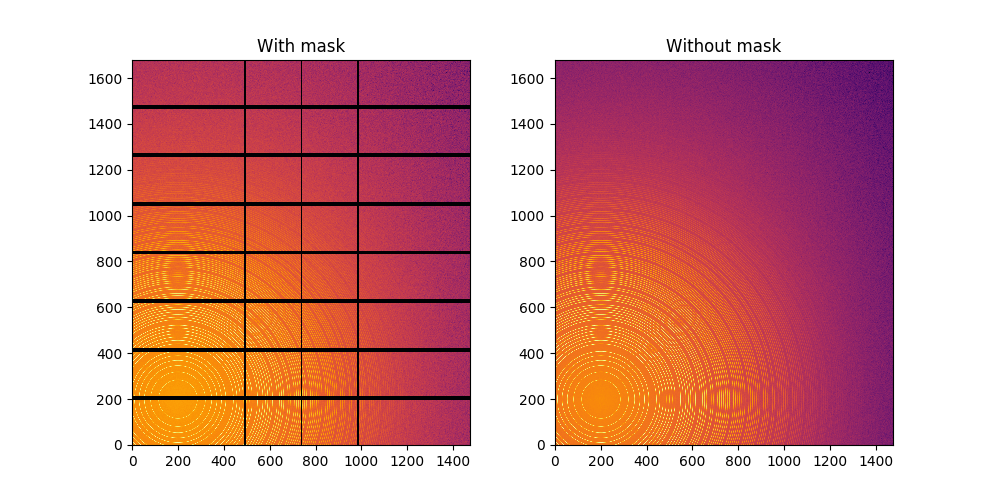

In [4]:
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = ai.wavelength
print(LaB6)
r = ai.array_from_unit(unit="q_nm^-1")
decay_b = numpy.exp(-(r-50)**2/2000)
bragg = LaB6.fake_calibration_image(ai, Imax=1e4, W=1e-6) * ai.polarization(factor=1.0) * decay_b
decay_a = numpy.exp(-r/100)
amorphous = 1000*ai.polarization(factor=1.0)*ai.solidAngleArray() * decay_a
img_nomask = bragg + amorphous
#Not the same noise function for all images two images
img_nomask = numpy.random.poisson(img_nomask)
img_nomask2 = numpy.random.poisson(img_nomask)
img = numpy.random.poisson(img_nomask)
img[numpy.where(mask)] = -1
fig,ax = subplots(1,2, figsize=(10,5))
jupyter.display(img=img, label="With mask", ax=ax[0])
jupyter.display(img=img_nomask, label="Without mask", ax=ax[1])

Note the aliassing effect on the displayed images.

We will measure now the effect after 1D intergeration. We do not correct for polarization on purpose to highlight the defect one wishes to whipe out. We use a R-factor to describe the quality of the 1D-integrated signal. 

<IPython.core.display.Javascript object>


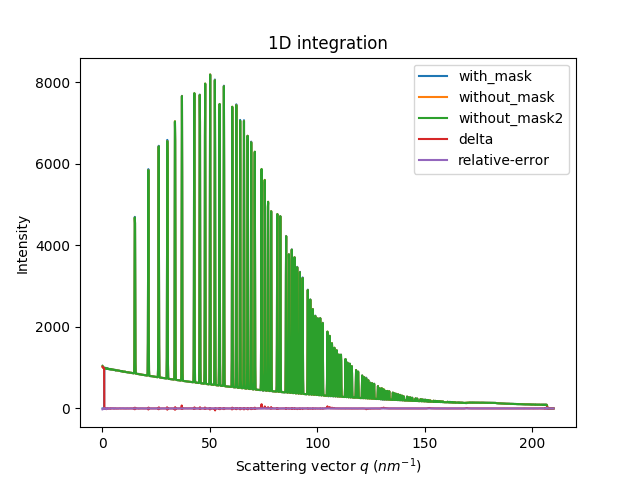

Between masked and non masked image R= 5.720645855177775
Between two different non-masked images R'= 0.312189841160923


In [5]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo2 = ai.integrate1d(img_nomask2, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wm = ai.integrate1d(img, 2000, unit="q_nm^-1", method="splitpixel", mask=mask, radial_range=(0,210))
ax = jupyter.plot1d(wm , label="with_mask")
ax.plot(*wo, label="without_mask")
ax.plot(*wo2, label="without_mask2")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.plot(wo.radial, wo.intensity-wo2.intensity, label="relative-error")
ax.legend()
print("Between masked and non masked image R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))
print("Between two different non-masked images R'= %s"%pyFAI.utils.mathutil.rwp(wo2,wo))

<IPython.core.display.Javascript object>


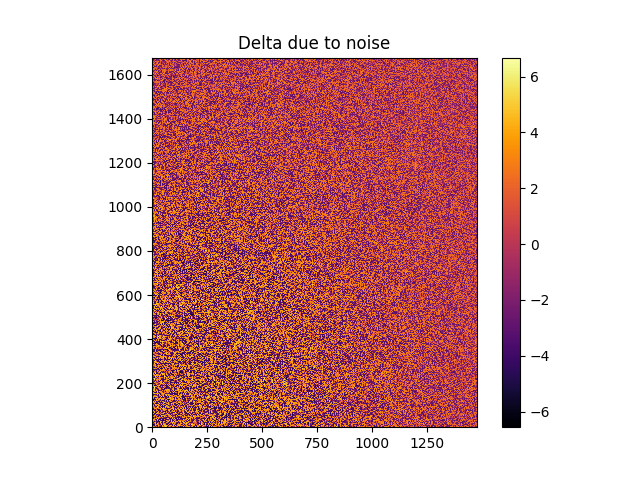

In [6]:
# Effect of the noise on the delta image
fig, ax = subplots()
jupyter.display(img=img_nomask-img_nomask2, label="Delta due to noise", ax=ax)
ax.figure.colorbar(ax.images[0])

## Inpainting

This part describes how to paint the missing pixels for having a "natural-looking image". The delta image contains the difference with the original image

  File "/users/kieffer/VirtualEnvs/py372_rebuild/lib/python3.7/site-packages/pyFAI/azimuthalIntegrator.py", line 3080, in inpainting
    imgb = self.integrate2d(blank_data, **kwargs)
  File "/users/kieffer/VirtualEnvs/py372_rebuild/lib/python3.7/site-packages/pyFAI/azimuthalIntegrator.py", line 3081, in inpainting
    imgp = self.integrate2d(masked, **kwargs)
  File "/users/kieffer/VirtualEnvs/py372_rebuild/lib/python3.7/site-packages/pyFAI/azimuthalIntegrator.py", line 3082, in inpainting
    imgd = self.integrate2d(masked_data, **kwargs)


<IPython.core.display.Javascript object>


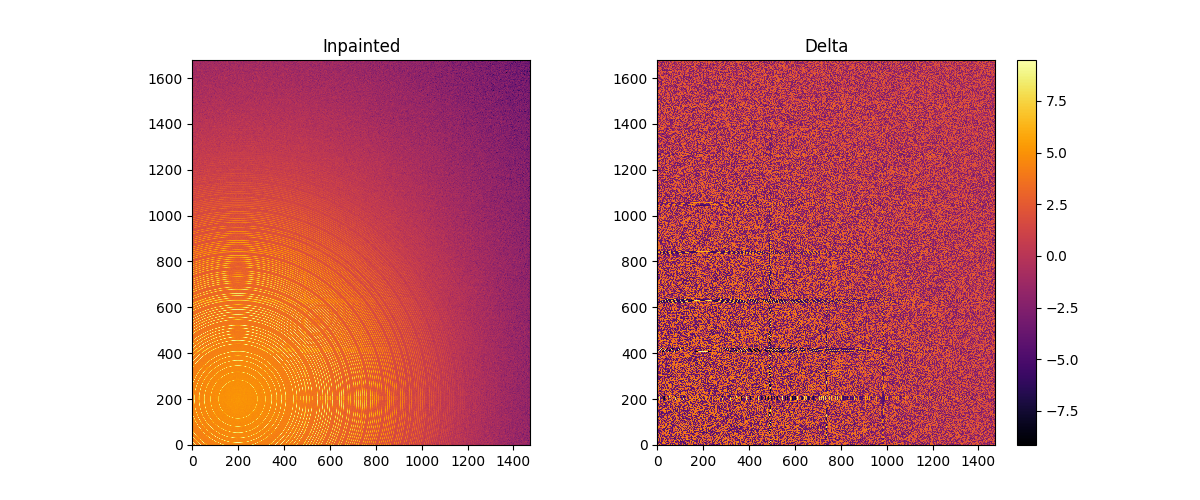

In [7]:
#Inpainting:
inpainted = ai.inpainting(img, mask=mask, poissonian=True)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


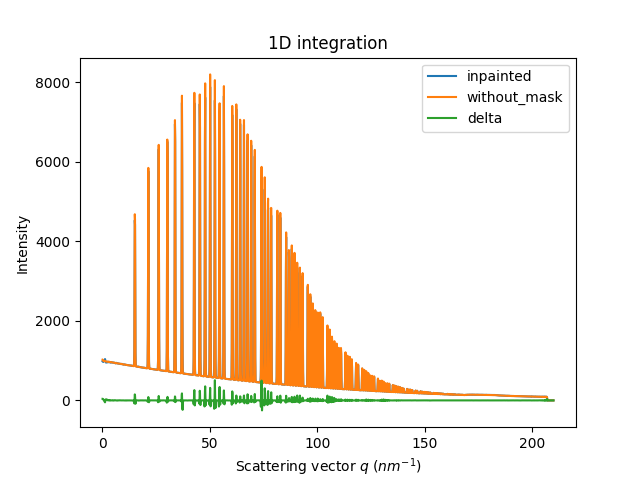

R= 1.491079853284347


In [8]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

One can see by zooming in that the main effect on inpainting is a broadening of the signal in the inpainted region. This could (partially) be adressed by increasing the number of radial bins used in the inpainting.

## Benchmarking and optimization of the parameters

The parameter set depends on the detector, the experiment geometry and the type of signal on the detector. Finer detail require finer slicing.

In [9]:
#Basic benchmarking of execution time for default options:
%timeit inpainted = ai.inpainting(img, mask=mask)

449 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
for j in ("csr", "csr_nosplit"):
    for k in (512,1024,2048, 4096):
        ai.reset()
        for i in range(10):
            inpainted = ai.inpainting(img, mask=mask, poissonian=True, method=j, npt_rad=k, grow_mask=i)
            wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
            print("method: %s npt_rad=%i grow=%i; R= %s"%(j, k, i,pyFAI.utils.mathutil.rwp(wm,wo)))

method: csr npt_rad=512 grow=0; R= 3.247238664402691


method: csr npt_rad=512 grow=1; R= 2.995485879417864


method: csr npt_rad=512 grow=2; R= 2.8045672163514075


method: csr npt_rad=512 grow=3; R= 2.756627572538062


method: csr npt_rad=512 grow=4; R= 2.721289755231646


method: csr npt_rad=512 grow=5; R= 2.6799036065733226


method: csr npt_rad=512 grow=6; R= 2.647624863030405


method: csr npt_rad=512 grow=7; R= 2.6549646409522616


method: csr npt_rad=512 grow=8; R= 2.645610020199982


method: csr npt_rad=512 grow=9; R= 2.6278179272066473


method: csr npt_rad=1024 grow=0; R= 1.836826089619943


method: csr npt_rad=1024 grow=1; R= 1.5102404127187472


method: csr npt_rad=1024 grow=2; R= 1.5068076454994148


method: csr npt_rad=1024 grow=3; R= 1.4913169547624305


method: csr npt_rad=1024 grow=4; R= 1.472557904284533


method: csr npt_rad=1024 grow=5; R= 1.4722151423077934


method: csr npt_rad=1024 grow=6; R= 1.4693236686681053


method: csr npt_rad=1024 grow=7; R= 1.4685396648425166


method: csr npt_rad=1024 grow=8; R= 1.462380340235771


method: csr npt_rad=1024 grow=9; R= 1.4576029123920007


method: csr npt_rad=2048 grow=0; R= 1.1581735546949181


method: csr npt_rad=2048 grow=1; R= 0.9827567976836381


method: csr npt_rad=2048 grow=2; R= 0.9704243988179665


method: csr npt_rad=2048 grow=3; R= 0.966592363273862


method: csr npt_rad=2048 grow=4; R= 0.9678592716281511


method: csr npt_rad=2048 grow=5; R= 0.9681983352826804


method: csr npt_rad=2048 grow=6; R= 0.9702996137899719


method: csr npt_rad=2048 grow=7; R= 0.9660131072867357


method: csr npt_rad=2048 grow=8; R= 0.9634446210930393


method: csr npt_rad=2048 grow=9; R= 0.9687240254242545


method: csr npt_rad=4096 grow=0; R= 0.9270882623516873


method: csr npt_rad=4096 grow=1; R= 0.8425785086389372


method: csr npt_rad=4096 grow=2; R= 0.8429210323130858


method: csr npt_rad=4096 grow=3; R= 0.8434627682114081


method: csr npt_rad=4096 grow=4; R= 0.8427458725597526


method: csr npt_rad=4096 grow=5; R= 0.8406509824839591


method: csr npt_rad=4096 grow=6; R= 0.8415003346019121


method: csr npt_rad=4096 grow=7; R= 0.8441533992997535


method: csr npt_rad=4096 grow=8; R= 0.839037119963112


method: csr npt_rad=4096 grow=9; R= 0.843536945166294


method: csr_nosplit npt_rad=512 grow=0; R= 3.9285140540005745


method: csr_nosplit npt_rad=512 grow=1; R= 3.0495107687874077


method: csr_nosplit npt_rad=512 grow=2; R= 2.774723844401803


method: csr_nosplit npt_rad=512 grow=3; R= 2.714309783225979


method: csr_nosplit npt_rad=512 grow=4; R= 2.686194711501383


method: csr_nosplit npt_rad=512 grow=5; R= 2.7122899585691487


method: csr_nosplit npt_rad=512 grow=6; R= 2.689491208085995


method: csr_nosplit npt_rad=512 grow=7; R= 2.6501430605378276


method: csr_nosplit npt_rad=512 grow=8; R= 2.6249337420208176


method: csr_nosplit npt_rad=512 grow=9; R= 2.6239420102946536


method: csr_nosplit npt_rad=1024 grow=0; R= 2.8811187635422373


method: csr_nosplit npt_rad=1024 grow=1; R= 1.6283496891571563


method: csr_nosplit npt_rad=1024 grow=2; R= 1.5417238332171008


method: csr_nosplit npt_rad=1024 grow=3; R= 1.494286188111872


method: csr_nosplit npt_rad=1024 grow=4; R= 1.4771344048856858


method: csr_nosplit npt_rad=1024 grow=5; R= 1.4914921900669613


method: csr_nosplit npt_rad=1024 grow=6; R= 1.3874455486214279


method: csr_nosplit npt_rad=1024 grow=7; R= 1.3594719207234216


method: csr_nosplit npt_rad=1024 grow=8; R= 1.3611262673921818


method: csr_nosplit npt_rad=1024 grow=9; R= 1.3781383155809623


method: csr_nosplit npt_rad=2048 grow=0; R= 2.899492294128138


method: csr_nosplit npt_rad=2048 grow=1; R= 1.4413193053012254


method: csr_nosplit npt_rad=2048 grow=2; R= 1.346304600659259


method: csr_nosplit npt_rad=2048 grow=3; R= 1.2886590155153264


method: csr_nosplit npt_rad=2048 grow=4; R= 1.245520712817661


method: csr_nosplit npt_rad=2048 grow=5; R= 1.1575515522187212


method: csr_nosplit npt_rad=2048 grow=6; R= 1.0965689004230161


method: csr_nosplit npt_rad=2048 grow=7; R= 1.0800093173510321


method: csr_nosplit npt_rad=2048 grow=8; R= 1.0970213595561313


method: csr_nosplit npt_rad=2048 grow=9; R= 1.052000310743321


method: csr_nosplit npt_rad=4096 grow=0; R= 2.791321240968174


method: csr_nosplit npt_rad=4096 grow=1; R= 1.4232395086463658


method: csr_nosplit npt_rad=4096 grow=2; R= 1.3865706022083646


method: csr_nosplit npt_rad=4096 grow=3; R= 1.381620525473178


method: csr_nosplit npt_rad=4096 grow=4; R= 1.3632143737840199


method: csr_nosplit npt_rad=4096 grow=5; R= 1.3420423483412525


method: csr_nosplit npt_rad=4096 grow=6; R= 1.3079166509321225


method: csr_nosplit npt_rad=4096 grow=7; R= 1.283944029653266


method: csr_nosplit npt_rad=4096 grow=8; R= 1.2514262611118365


method: csr_nosplit npt_rad=4096 grow=9; R= 1.2087902352250106


CPU times: user 3.45 s, sys: 228 ms, total: 3.68 s
Wall time: 920 ms


<IPython.core.display.Javascript object>


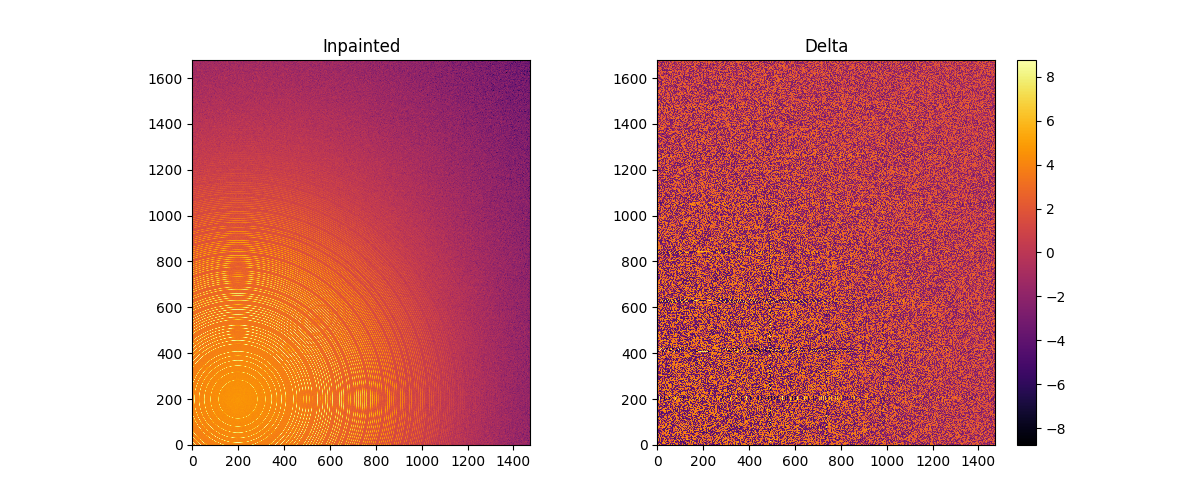

In [11]:
#Inpainting, best solution found:
ai.reset()
%time inpainted = ai.inpainting(img, mask=mask, poissonian=True, method="csr", npt_rad=4096, grow_mask=5)
fig, ax = subplots(1, 2, figsize=(12,5))
jupyter.display(img=inpainted, label="Inpainted", ax=ax[0])
jupyter.display(img=img_nomask-inpainted, label="Delta", ax=ax[1])
ax[1].figure.colorbar(ax[1].images[0])

<IPython.core.display.Javascript object>


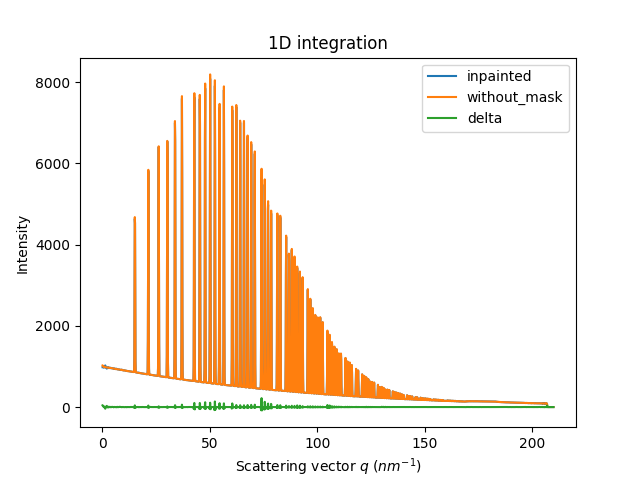

R= 0.8407537093923908


In [12]:
# Comparison of the inpained image with the original one:
wm = ai.integrate1d(inpainted, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
wo = ai.integrate1d(img_nomask, 2000, unit="q_nm^-1", method="splitpixel", radial_range=(0,210))
ax = jupyter.plot1d(wm , label="inpainted")
ax.plot(*wo, label="without_mask")
ax.plot(wo.radial, wo.intensity-wm.intensity, label="delta")
ax.legend()
print("R= %s"%pyFAI.utils.mathutil.rwp(wm,wo))

## Conclusion

Inpainting is one of the only solution to fill up the gaps in detector when Fourier analysis is needed. 
This tutorial explains basically how this is possible using the pyFAI library and how to optimize the parameter set for inpainting. The result may greatly vary with detector position and tilt and the kind of signal (amorphous or more spotty).

In [13]:
print("Execution time: %.3fs"%(time.time()-start_time))

Execution time: 56.961s
